# Classical Method: Random Forest

The objective is to compare the performance of a Random Forest based on extracted features and one based on a tf-idf vectorization of the text field.

In [1]:
import matplotlib.pyplot as plt  
import pandas as pd
import seaborn as sns

In [2]:
full_filepath = "/Users/ppanero/Workspace/zenodo/zenodo-spam-classifier/zenodo_open_metadata_2020-10-19_processed.jsonl"
full_df = pd.read_json(full_filepath, lines=True)  # The file is JSONLines
full_df = full_df.set_index('recid')

In [26]:
import joblib

from collections import Counter
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

Needed for the feature based approach:

In [4]:
from sklearn.preprocessing import OneHotEncoder

Needed for the text based approach:

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

**Function definitions**

In [6]:
def plot_conf_mat(conf_mat):
    plt.figure()
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, cbar=False, fmt='g') #annot=True to annotate cells

    # TN | FP
    #--------
    # FN | TN
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Ham', 'Spam'])
    ax.yaxis.set_ticklabels(['Ham', 'Spam'])

In [28]:
def save_model(model, filename, path="models"):
    models_dir = Path(path)
    joblib.dump(model, models_dir / filename)

## Extracted Features RF

In [7]:
full_df.head()

,access_right,spam,num_keywords,num_files,has_image,num_communities,num_creators,creator_has_orcid,creator_has_affiliation,type,type_full,num_words_title,num_words_description,text,has_license
recid,,,,,,,,,,,,,,,
3900603,open,False,0,3,False,1,1,True,True,software,software-None,4,100,the geodynamic world builder the geodynamic w...,other
3363990,open,False,6,5,False,0,3,True,True,publication,publication-article,30,75,alignment ambiguous characters indel maximum l...,CC-BY-4.0
3363503,open,False,8,1,True,1,7,False,False,image,image-figure,24,75,biodiversity taxonomy animalia arthropoda inse...,notspecified
3363619,open,False,8,1,True,1,1,False,False,image,image-figure,21,50,biodiversity taxonomy animalia arthropoda maxi...,notspecified
3363729,closed,False,7,0,False,1,3,False,False,publication,publication-article,14,30,biodiversity taxonomy animalia arthropoda inse...,no-license


In [8]:
ef_df = full_df.drop("text", axis='columns')

In [9]:
ef_df.dtypes

access_right               object
spam                         bool
num_keywords                int64
num_files                   int64
has_image                    bool
num_communities             int64
num_creators                int64
creator_has_orcid            bool
creator_has_affiliation      bool
type                       object
type_full                  object
num_words_title             int64
num_words_description       int64
has_license                object
dtype: object

In [10]:
for col in ef_df.columns:
    ef_df[col] = ef_df[col].astype('category')
ef_df.dtypes

access_right               category
spam                       category
num_keywords               category
num_files                  category
has_image                  category
num_communities            category
num_creators               category
creator_has_orcid          category
creator_has_affiliation    category
type                       category
type_full                  category
num_words_title            category
num_words_description      category
has_license                category
dtype: object

In [11]:
# Split dataset
labels_ef = list(ef_df['spam'])
data_ef = ef_df.drop("spam", axis='columns')
X_train_ef, X_test_ef, y_train_ef, y_test_ef = train_test_split(data_ef, labels_ef, test_size=0.33, random_state=422)

In [12]:
# Random forest model
pipeline_ef = Pipeline([
    ("ohe", OneHotEncoder()),
    ("clf", RandomForestClassifier(n_estimators=100, n_jobs=4, verbose=True)),
])

# Trains the model. This might take some time (~30min)
feature_clf = pipeline_ef.fit(X_train_ef, y_train_ef)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.1min finished


In [29]:
save_model(feature_clf, '2020_10_27_features_record_spam.pkl')

In [13]:
y_pred_ef = feature_clf.predict(X_test_ef)
acc = [(ref, pred) for ref, pred in zip(y_test_ef, y_pred_ef)]
c = Counter(acc)
print(c)
print("Spam->Spam: {0:.4f}".format(c[(True, True)] / (c[(True, True)] + c[(True, False)])))
print("Ham -> Ham: {0:.4f}".format(c[(False, False)] / (c[(False, False)] + c[(False, True)])))
print("Accuracy: {0:.4f}".format((c[(False, False)] + c[(True, True)] ) / (len(acc))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


Counter({(False, False): 555400, (True, True): 10926, (True, False): 1405, (False, True): 630})
Spam->Spam: 0.8861
Ham -> Ham: 0.9989
Accuracy: 0.9964


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


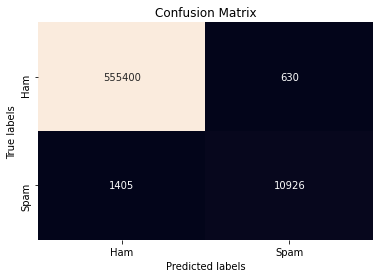

In [14]:
cm_ef = confusion_matrix(y_pred=y_pred_ef, y_true=y_test_ef)
plot_conf_mat(cm_ef)

## Text based RF

In [15]:
full_df.head()

,access_right,spam,num_keywords,num_files,has_image,num_communities,num_creators,creator_has_orcid,creator_has_affiliation,type,type_full,num_words_title,num_words_description,text,has_license
recid,,,,,,,,,,,,,,,
3900603,open,False,0,3,False,1,1,True,True,software,software-None,4,100,the geodynamic world builder the geodynamic w...,other
3363990,open,False,6,5,False,0,3,True,True,publication,publication-article,30,75,alignment ambiguous characters indel maximum l...,CC-BY-4.0
3363503,open,False,8,1,True,1,7,False,False,image,image-figure,24,75,biodiversity taxonomy animalia arthropoda inse...,notspecified
3363619,open,False,8,1,True,1,1,False,False,image,image-figure,21,50,biodiversity taxonomy animalia arthropoda maxi...,notspecified
3363729,closed,False,7,0,False,1,3,False,False,publication,publication-article,14,30,biodiversity taxonomy animalia arthropoda inse...,no-license


In [16]:
# Split dataset
labels_tb = full_df['spam']
data_tb = full_df["text"]
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(data_tb, labels_tb, test_size=0.33, random_state=422)

In [17]:
# Random forest model
pipeline_tb = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=8000, ngram_range=(1, 1), analyzer='word', stop_words='english')),
    ("clf", RandomForestClassifier(n_estimators=100, n_jobs=4, verbose=True)),
])

# Trains the model. This might take some time (~30min)
text_clf = pipeline_tb.fit(X_train_tb, y_train_tb)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 22.3min finished


In [30]:
save_model(text_clf, '2020_10_27_text_record_spam.pkl')

In [18]:
from collections import Counter

y_pred_tb = text_clf.predict(X_test_tb)
acc = [(ref, pred) for ref, pred in zip(y_test_tb, y_pred_tb)]
c = Counter(acc)
print(c)
print("Spam->Spam: {0:.4f}".format(c[(True, True)] / (c[(True, True)] + c[(True, False)])))
print("Ham -> Ham: {0:.4f}".format(c[(False, False)] / (c[(False, False)] + c[(False, True)])))
print("Accuracy: {0:.4f}".format((c[(False, False)] + c[(True, True)] ) / (len(acc))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   10.7s finished


Counter({(False, False): 555883, (True, True): 11340, (True, False): 991, (False, True): 147})
Spam->Spam: 0.9196
Ham -> Ham: 0.9997
Accuracy: 0.9980


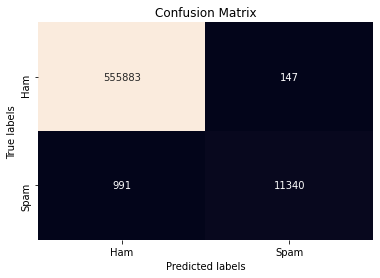

In [19]:
cm_tb = confusion_matrix(y_pred=y_pred_tb, y_true=y_test_tb)
plot_conf_mat(cm_tb)

## Check results

In order to verify levels of contamination, check the records that both models detected as spam but was originally classified as ham.

In [37]:
def get_fp(refs, preds):
    fps = []
    for idx, rec in enumerate(zip(refs, preds)):
        ref, pred = rec[0], rec[1]
        if not ref and pred:
            fps.append(full_df.index[idx])
    return fps

In [38]:
feature_fp = get_fp(y_test_ef, y_pred_ef)
print(f"{len(feature_fp)} false positives with feature extraction.")
text_fp = get_fp(y_test_tb, y_pred_tb)
print(f"{len(text_fp)} false positives with text vectorization.")
intersect_fp = set(feature_fp).intersection(set(text_fp))
print(f"{len(intersect_fp)} false positives are in both sets.""")

630 false positives with feature extraction.
147 false positives with text vectorization.
22 false positives are in both sets.


In [41]:
for recid in intersect_fp:
    print(f"https://zenodo.org/record/{recid}")

https://zenodo.org/record/3515392
https://zenodo.org/record/1000963
https://zenodo.org/record/4063619
https://zenodo.org/record/3942535
https://zenodo.org/record/196873
https://zenodo.org/record/1296401
https://zenodo.org/record/971154
https://zenodo.org/record/3527195
https://zenodo.org/record/439068
https://zenodo.org/record/260003
https://zenodo.org/record/164135
https://zenodo.org/record/270895
https://zenodo.org/record/235831
https://zenodo.org/record/9027
https://zenodo.org/record/3594323
https://zenodo.org/record/44637
https://zenodo.org/record/1255143
https://zenodo.org/record/1085800
https://zenodo.org/record/1310443
https://zenodo.org/record/216688
https://zenodo.org/record/1151218
https://zenodo.org/record/249469


The previous 22 records were manually checked, they are ham. Therefore the model made a mistake.